<div style="width: 1350px; height: 30px; background-color: green;"></div>


# TO DO

##### **Cross Validation**
- Currently, we are using cross-entropy for the criterion, but according to ChatGPT, it has nothing to do with cross-validation, and I think that makes sense.
- We want to use cross-validation to somehow max the F1 score
  - We are minimizing loss, but somehow we want to maximize F1 score during cross validation (see feedback Project 1)
  - Currently the `train_acc_history` doesn't work well. At each epoch it returns the acc for ALL minibatches. Therefore, at the end of the 5 epochs instead of containing 5 values, it contains 20 (5 epochs x 4 minibatches). I think that with cross-validation we have to take the average of them ?? 

##### **Other**
- Parameter tuning: get cool hyperparameters (criterion, number of epochs, optimizer, scheduler)
- Data Augmentation: transformations (rotations, translations, cutouts, zoom in, zoom out...)
- Multimodal data: currently we only train the image itself. Maybe it's useful to train other parameters such as the date or the location, as Sophie said that if a jet occurs in a location, it is more likely that another jet occurs in that same location.
- Batch size set to 32. Change it?

##### **Model Testing**
- We have to divide data into training, validation, and test. BUT, as we are using cross validation we don't need the validation set I think???
- Need to evaluate and test model

##### **Network Model**
- I didn't include the first two layers from the paper (input layer and BRN). Should we? CAREFUL AS THIS MAY REBOOT THE LAPTOP
- Batch **re**normalization ?
- Part of me thinks that this model is better when we have small images but with a lot of samples, because using 127 datapoints (which is low but not that low), it only takes 2 min to run even when running on CPU, which seems like so little time.

<div style="width: 1350px; height: 30px; background-color: green;"></div>


# 0. Load Modules

In [14]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [15]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    folder0_path = '/content/drive/My Drive/solar_jets/data0'
    folder1_path = '/content/drive/My Drive/solar_jets/data1'
else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'

# 1. Very naive Model

## 1.1. Prepare the dataset

#### Create the class

In [16]:
class NPZDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

#### Run to get the Data

In [17]:
train_data1 = NPZDataset(folder1_path)
train_data0 = NPZDataset(folder0_path)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

Below we'll see how train_data can be treated just like lists

- One element in the list for each sequence of images
- Each element of the list has a tuple of two elements, the first the array (166,30,30) and the second the label

In [18]:
print("samples y=1: ",len(train_data1))
print("samples y=0: ",len(train_data0))
print("samples total ",len(train_data))

samples y=1:  866
samples y=0:  846
samples total  1712


In [19]:
print(f"Sample {0}: Shape {train_data1[0][0].shape}, Label: {train_data1[0][1]}")
print(f"Sample {0}: Shape {train_data0[0][0].shape}, Label: {train_data0[0][1]}")

Sample 0: Shape torch.Size([30, 166, 166]), Label: 1.0
Sample 0: Shape torch.Size([30, 166, 166]), Label: 0.0


#### Get the Minibatch

In [20]:
train_size = int(0.8 * len(train_data))  # 80% of data for training
test_size = len(train_data) - train_size  # remaining 20% for testing
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

See that we have 4 different minibatches, each with 32 samples

In [22]:
print("Number of batches: ",len(train_loader))
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}: samples {x.shape[0]}")

Number of batches:  43
Batch 0: samples 32
Batch 1: samples 32
Batch 2: samples 32
Batch 3: samples 32
Batch 4: samples 32
Batch 5: samples 32
Batch 6: samples 32
Batch 7: samples 32
Batch 8: samples 32
Batch 9: samples 32
Batch 10: samples 32
Batch 11: samples 32
Batch 12: samples 32
Batch 13: samples 32
Batch 14: samples 32
Batch 15: samples 32
Batch 16: samples 32
Batch 17: samples 32
Batch 18: samples 32
Batch 19: samples 32
Batch 20: samples 32
Batch 21: samples 32
Batch 22: samples 32
Batch 23: samples 32
Batch 24: samples 32
Batch 25: samples 32
Batch 26: samples 32
Batch 27: samples 32
Batch 28: samples 32
Batch 29: samples 32
Batch 30: samples 32
Batch 31: samples 32
Batch 32: samples 32
Batch 33: samples 32
Batch 34: samples 32
Batch 35: samples 32
Batch 36: samples 32
Batch 37: samples 32
Batch 38: samples 32
Batch 39: samples 32
Batch 40: samples 32
Batch 41: samples 32
Batch 42: samples 25


DataLoader is designed to iterate over batches of data rather than individual samples, so when we try to access for example the first mini-batch as `train_loader[0]`, we get an error.

However, note how before we could iterate over it


# 2. Define the Neural Network

In [23]:
class RCNN(torch.nn.Module):
    
    def __init__(self):
        super(RCNN, self).__init__()

        # Define the layers

        # 1. Input layers
        #self.input_layer=torch.nn.Linear(in_features=166*166*30, out_features=166*166*30)      # not sure if this is needed
        #self.norm=torch.nn.BatchNorm2d(166*166*30)        #not sure this is sufficent for batch renormalization

        # 2. Convolutional layers

        # Three conv layers
        # according to gpt, in_channels=1 because in the sequence, it is still gray scale, not rgb
        self.conv1 = self.create_conv_layer(in_channels=30, out_channels=64)
        self.conv2 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv3 = self.create_conv_layer(in_channels=64, out_channels=64)

        # First maxpool
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Three conv layers
        self.conv4 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv5 = self.create_conv_layer(in_channels=64, out_channels=64)
        self.conv6 = self.create_conv_layer(in_channels=64, out_channels=64)

        # Second maxpool
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)

        # Flatten
        self.flatten=torch.nn.Flatten()

        # Each time we apply pooling, height and width are divided by 2
        self.flat_size = 64 * int(np.floor(166/2/2)) * int(np.floor(166/2/2))

        # Fully connected with dropout
        self.lin=torch.nn.Linear(self.flat_size, 1024)
        self.drop=torch.nn.Dropout(p=0.5)

        #LSTM
        # we set batch_first=True to have batch_size as first dimension: (30,166,166)
        self.lstm = torch.nn.LSTM(input_size=1024, hidden_size=512, num_layers=1, batch_first=True)

        #output: for binary classification softmax is not needed
        #self.output_layer=torch.nn.Softmax(dim=1)
        self.output = torch.nn.Linear(512, 1)

    # To make the code more clear, let's use this function to create conv layers
    def create_conv_layer(self, in_channels, out_channels):
        conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        relu = torch.nn.ReLU()
        norm = torch.nn.BatchNorm2d(out_channels)
        return torch.nn.Sequential(conv, relu, norm)



    def forward(self, x):
        
        # Define the forward pass

        # 1. Input layers
        #x=self.input_layer(x)
        #x=self.norm(x)

        # 2. Convolutional layers
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)

        # First maxpool
        x=self.pool1(x)

        # Three conv layers
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)

        # Second maxpool
        x=self.pool2(x)

        # Flatten
        x=self.flatten(x)

        # Fully connected with dropout
        x=self.lin(x)
        x=self.drop(x)

        #LSTM
        #x = x.view(x.size(0), -1, self.flat_size)
        #x = x.view(x.size(0), 30, -1)
        lstm_out, _ = self.lstm(x)
        #lstm_out = lstm_out[:, -1, :]

        #output
        out=self.output(lstm_out)
        
        return out.view(-1)

#### Define the model

In [24]:
model = RCNN()

# 3. Training Parameters

There is a lot that can be done here to get very cool hyperparameters

In [25]:
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 5

optimizer = torch.optim.AdamW(model.parameters())

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

# 4. Train Epoch Script

In [26]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        threshold = 0.5
        pred = (output >= threshold).float()
        correct = pred.eq(target.view_as(pred)).sum().item()
        loss_float = loss.item()
        accuracy_float = correct / len(data)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        
        # this is the if statement of the lab, but it doesn't work for me. it makes no sense to me tbh
        #if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
        # this doesn't work bad, but it just prints the last batch of the epoch
        if batch_idx == len(train_loader) - 1:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history

# 5. Test Script

In [27]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = (output >= 0.5).float()  # threshold for binary classification
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * test_accuracy:.2f}%)\n')
    return test_loss, test_accuracy


# 6. Train the Network 😀😀😀😀😀


In [28]:
# Training History
lr_history = []
train_loss_history = []
train_acc_history = []

# Validation History
val_loss_history = []
val_acc_history = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
    train_loss_history.extend(train_loss)
    train_acc_history.extend(train_acc)
    lr_history.extend(lrs)

    # Test the model after each epoch
    test_loss, test_accuracy = test_model(model, test_loader, criterion, device)
    val_loss_history.append(test_loss)
    val_acc_history.append(test_accuracy)


ValueError: x and y must have same first dimension, but have shapes (5,) and (20,)

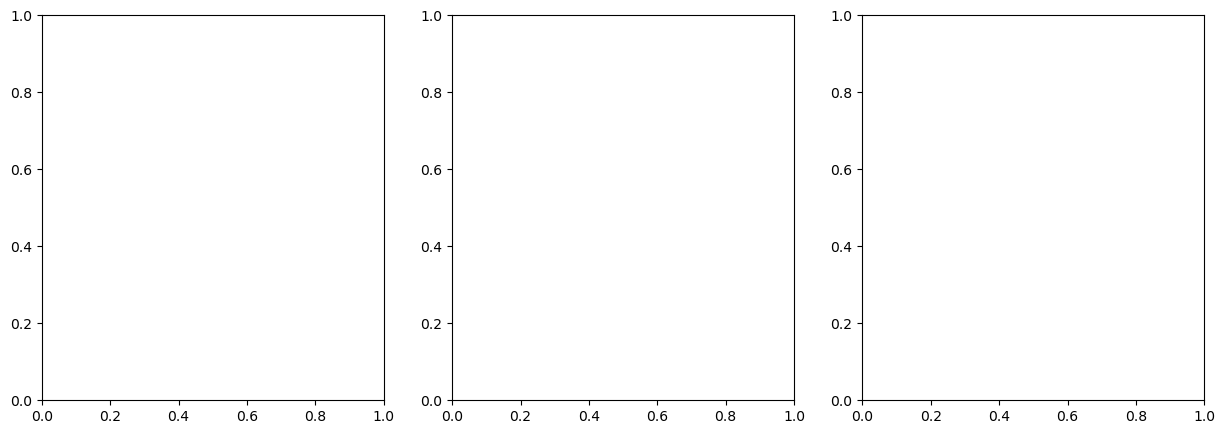

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting learning rate history
axs[0].plot(range(1, num_epochs + 1), lr_history, marker='o')
axs[0].set_title('Learning Rate History')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Learning Rate')

# Plotting training loss history
axs[1].plot(range(1, num_epochs + 1), train_loss_history, marker='o', color='r')
axs[1].set_title('Training Loss History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# Plotting training accuracy history
axs[2].plot(range(1, num_epochs + 1), train_acc_history, marker='o', color='g')
axs[2].set_title('Training Accuracy History')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# 5. Evaluate the Model